In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from gymnasium import spaces
from sklearn.preprocessing import MinMaxScaler

RATES_CSV_PATH = "../data/rates.csv"

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1500)

df = pd.read_csv(RATES_CSV_PATH)
df.set_index('time', inplace=True)

start_datetime = df.index[0]
end_datetime = df.index[-1]
print(f"Data collected from {start_datetime} to {end_datetime}")

df_scaled = df.copy()

scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_scaled), columns=df_scaled.columns, index=df_scaled.index)
df_scaled['unscaled_close'] = df['close']

print(df_scaled.tail())

# Split train/test (80/20)
split_idx = int(len(df) * 0.8)
train_data = df_scaled.iloc[:split_idx]
test_data = df_scaled.iloc[split_idx:]

Data collected from 2024-05-26 20:15:00 to 2025-02-10 19:00:00
                         open      high       low     close    volume  EMA_fast  EMA_medium  EMA_slow      MACD       RSI     Stoch  BB_upper  BB_middle  BB_lower       ATR           OBV      VWAP  unscaled_close
time                                                                                                                                                                                                                
2025-02-10 18:00:00  0.807395  0.793828  0.817016  0.804100  0.387897  0.812056    0.820920  0.822037  0.405066  0.485225  0.584962  0.768176   0.810346  0.819597  0.176755  4.126642e-14  0.808667        97308.17
2025-02-10 18:15:00  0.804160  0.792210  0.814976  0.806983  0.385744  0.812717    0.821143  0.822174  0.414843  0.528162  0.857210  0.768178   0.810347  0.819597  0.174617  4.155541e-14  0.808729        97478.74
2025-02-10 18:30:00  0.807072  0.793237  0.816175  0.803732  0.383511  0.812579    0.

In [2]:
def calculate_lot_size(balance, risk, entry_price, stop_loss, contract_size=1.0):
    """
    Calculate lot size as a function of a fixed percentage of balance (risk)
    """
    return min(max(round((balance * risk) / (abs(entry_price - stop_loss) * contract_size), 2), 0.01), 100.0)

def calculate_balance_change(lot_size, entry_price, exit_price, position, contract_size=1.0):
    """
    Calculate the profit or loss based on trade parameters.
    
    For a long trade (position == 1), profit = (exit_price - entry_price) * lot_size * contract_size.
    For a short trade (position == -1), profit = (entry_price - exit_price) * lot_size * contract_size.
    """
    if position == 1:
        return (exit_price - entry_price) * lot_size * contract_size
    elif position == -1:
        return (entry_price - exit_price) * lot_size * contract_size
    else:
        return 0.0


class BitcoinTradingEnv(gym.Env):
    def __init__(self, data, initial_balance=10000, lot_percentage=0.01):
        super(BitcoinTradingEnv, self).__init__()
        self.data = data
        self.current_step = 0
        self.initial_balance = initial_balance
        self.balance = initial_balance
        self.lot_percentage = lot_percentage
        self.trades = []
        self.open_positions = []  # Allows multiple concurrently open positions

        # Define discrete price differences for SL/TP
        self.sl_tp_levels = np.array([100, 200, 300, 400, 500, 600, 700, 800, 900, 1000])

        # Action space: (trade action, stop-loss index, take-profit index)
        self.action_space = spaces.MultiDiscrete([
            3,  # 0: Hold, 1: Buy, 2: Sell
            len(self.sl_tp_levels),  # Stop-Loss selection
            len(self.sl_tp_levels)   # Take-Profit selection
        ])

        # Observation space (OHLCV + indicators)
        obs_dim = data.shape[1]
        self.observation_space = spaces.Box(low=-1e6, high=1e6, shape=(obs_dim,), dtype=np.float32)

    def step(self, action):
        trade_action, sl_index, tp_index = action
        current_price = self.data.iloc[self.current_step]["unscaled_close"]

        # Increment step and check if episode is done
        self.current_step += 1
        done = self.current_step >= len(self.data) - 1

        # Initialize reward for this step
        reward = 0

        # Loop through open positions and calculate base reward
        for pos in self.open_positions:
            reward += calculate_balance_change(pos["lot_size"], pos["entry_price"], current_price, pos["position"])

        # New trade execution based on action
        sl_value = self.sl_tp_levels[sl_index]
        tp_value = self.sl_tp_levels[tp_index]

        if trade_action == 1:  # Buy
            new_position = {
                "position": 1,
                "entry_price": current_price,
                "sl_price": current_price - sl_value,
                "tp_price": current_price + tp_value,
                "lot_size": calculate_lot_size(self.balance, self.lot_percentage, current_price, current_price - sl_value)
            }
            self.open_positions.append(new_position)
            reward += 2

        elif trade_action == 2:  # Sell
            new_position = {
                "position": -1,
                "entry_price": current_price,
                "sl_price": current_price + sl_value,
                "tp_price": current_price - tp_value,
                "lot_size": calculate_lot_size(self.balance, self.lot_percentage, current_price, current_price + sl_value)
            }
            self.open_positions.append(new_position)
            reward += 2

        elif trade_action == 0:  # Inaction
            reward -= 5.0

        # Check all open positions for SL or TP triggers
        closed_positions = []
        for pos in self.open_positions:
            if pos["position"] == 1:
                # For long trades: TP if price has risen; SL if dropped
                if current_price >= pos["tp_price"]:
                    profit = calculate_balance_change(pos["lot_size"], pos["entry_price"], pos["tp_price"], pos["position"])
                    reward += (profit / self.balance) * 100
                    self.balance += profit
                    pos["exit"] = current_price
                    pos["reward"] = (profit / self.balance) * 100
                    pos["pnl"] = profit
                    closed_positions.append(pos)
                elif current_price <= pos["sl_price"]:
                    loss = -calculate_balance_change(pos["lot_size"], pos["entry_price"], pos["sl_price"], pos["position"])
                    reward += -(loss / self.balance) * 100
                    self.balance -= loss
                    pos["exit"] = current_price
                    pos["reward"] = -(loss / self.balance) * 100
                    pos["pnl"] = -loss
                    closed_positions.append(pos)
            elif pos["position"] == -1:
                # For short trades: TP if price has fallen; SL if risen
                if current_price <= pos["tp_price"]:
                    profit = calculate_balance_change(pos["lot_size"], pos["entry_price"], pos["tp_price"], pos["position"])
                    reward += (profit / self.balance) * 100
                    self.balance += profit
                    pos["exit"] = current_price
                    pos["reward"] = (profit / self.balance) * 100
                    pos["pnl"] = profit
                    closed_positions.append(pos)
                elif current_price >= pos["sl_price"]:
                    loss = -calculate_balance_change(pos["lot_size"], pos["entry_price"], pos["sl_price"], pos["position"])
                    reward += -(loss / self.balance) * 100
                    self.balance -= loss
                    pos["exit"] = current_price
                    pos["reward"] = -(loss / self.balance) * 100
                    pos["pnl"] = -loss
                    closed_positions.append(pos)

        # Remove closed positions from open_positions and record them
        for pos in closed_positions:
            self.trades.append(pos)
            self.open_positions.remove(pos)

        # Optional bonus for consecutive winning trades
        if len(self.trades) > 1 and self.trades[-1]["pnl"] > 0 and self.trades[-2]["pnl"] > 0:
            reward += 1

        # Bankruptcy and end-of-episode adjustments
        if self.balance <= 0:
            self.balance = 0
            done = True

        if done and (self.balance > self.initial_balance):
            reward += (self.balance - self.initial_balance) * 0.1

        if done and len(self.trades) == 0:
            reward -= 5

        obs = self.data.iloc[self.current_step].values
        # Gymnasium expects (obs, reward, terminated, truncated, info)
        terminated = done
        truncated = False
        info = {}
        return obs, reward, terminated, truncated, info

    def reset(self, seed=None, options=None):
        if seed is not None:
            np.random.seed(seed)
        self.current_step = 0
        self.balance = self.initial_balance
        self.open_positions = []
        self.trades = []
        return self.data.iloc[self.current_step].values, {}

    def _get_obs(self):
        return self.data.iloc[self.current_step].values

from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env

#seed_value = np.random.randint(0, 100000)
seed_value = 52131
print(f"Using seed: {seed_value}")

env = BitcoinTradingEnv(df_scaled)
vec_env = make_vec_env(lambda: env, n_envs=1, seed=seed_value)

model = PPO("MlpPolicy", vec_env, verbose=0, n_epochs=10, learning_rate=0.001, ent_coef=0.01, gamma=0.95, clip_range=0.2)
model.learn(total_timesteps=100000, progress_bar=True)
model.save(f"./../results/{seed_value}")

Using seed: 52131


Output()

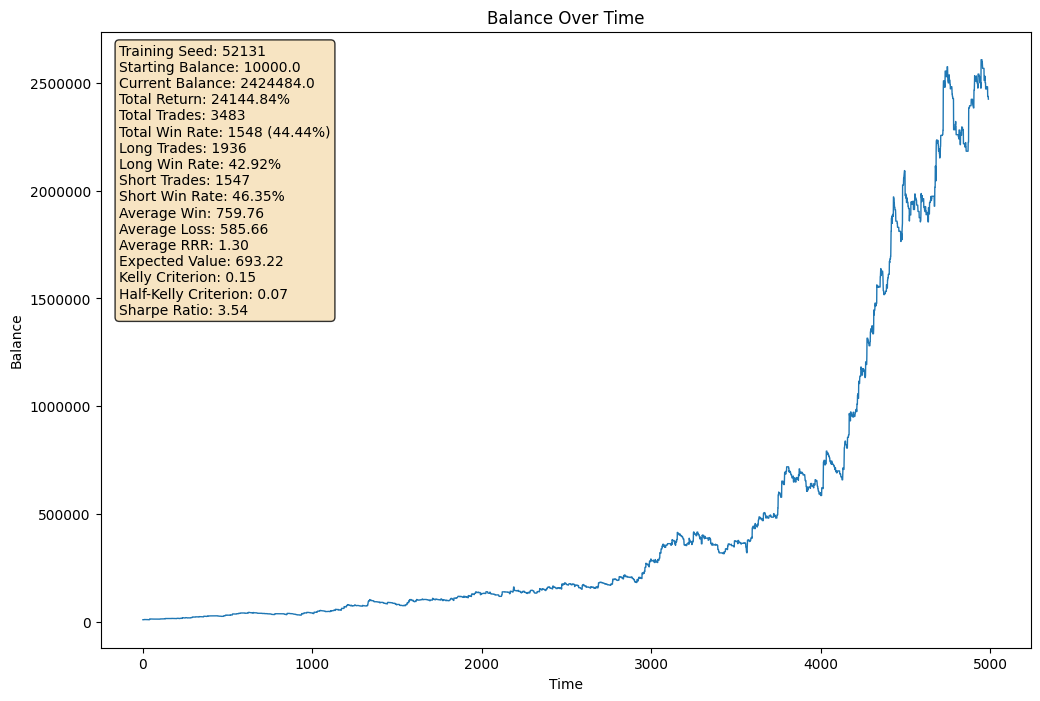

In [3]:
# Instantiate a test environment using test_data
test_env = BitcoinTradingEnv(test_data, initial_balance=10000.0)

# Reset the test environment and get initial observation
obs, info = test_env.reset()

balance_over_time = []
actions_log = []
done = False

while not done:
    action, _ = model.predict(obs)
    actions_log.append(action)
    obs, reward, done, truncated, info = test_env.step(action)
    balance_over_time.append(test_env.balance)

# Convert the list of completed trades to a DataFrame
trades_df = pd.DataFrame(test_env.trades)

def classify_trade(row):
    # For a long trade (position == 1): TP when exit > entry, SL otherwise.
    # For a short trade (position == -1): TP when exit < entry, SL otherwise.
    if row["position"] == 1:
        return "TP" if row["exit"] > row["entry_price"] else "SL"
    elif row["position"] == -1:
        return "TP" if row["exit"] < row["entry_price"] else "SL"
    else:
        return "Unknown"

trades_df["trade_type"] = trades_df.apply(classify_trade, axis=1)

total_trades = len(trades_df)
num_tp = trades_df[trades_df["trade_type"] == "TP"].shape[0]
num_sl = trades_df[trades_df["trade_type"] == "SL"].shape[0]

perc_tp = (num_tp / total_trades * 100) if total_trades > 0 else 0.0
perc_sl = (num_sl / total_trades * 100) if total_trades > 0 else 0.0

avg_pnl_tp = trades_df[trades_df["trade_type"] == "TP"]["pnl"].mean() if num_tp > 0 else 0.0
avg_pnl_sl = trades_df[trades_df["trade_type"] == "SL"]["pnl"].mean() if num_sl > 0 else 0.0

# Compute a basic Sharpe ratio using trade pnl as returns (assume risk-free rate = 0)
returns = trades_df["pnl"]
if returns.std() > 0:
    sharpe_ratio = returns.mean() / returns.std() * np.sqrt(len(returns))
else:
    sharpe_ratio = np.nan

total_return = ((test_env.balance - test_env.initial_balance) / test_env.initial_balance) * 100
expected_value = trades_df["pnl"].mean() if total_trades > 0 else 0.0

# Compute mean win and mean loss using absolute difference between exit and entry prices and trade_type
trades_df["abs_diff"] = abs(trades_df["exit"] - trades_df["entry_price"])
mean_win = trades_df[trades_df["trade_type"] == "TP"]["abs_diff"].mean() if not trades_df[trades_df["trade_type"] == "TP"].empty else 0.0
mean_loss = trades_df[trades_df["trade_type"] == "SL"]["abs_diff"].mean() if not trades_df[trades_df["trade_type"] == "SL"].empty else 0.0

num_buy = trades_df[trades_df["position"] == 1].shape[0]
num_sell = trades_df[trades_df["position"] == -1].shape[0]

buy_win_rate = trades_df[(trades_df["position"] == 1) & (trades_df["trade_type"] == "TP")].shape[0] / num_buy * 100 if num_buy > 0 else 0.0
sell_win_rate = trades_df[(trades_df["position"] == -1) & (trades_df["trade_type"] == "TP")].shape[0] / num_sell * 100 if num_sell > 0 else 0.0

rrr = mean_win / mean_loss if mean_loss > 0 else 0.0
kelly_criteria = (rrr * perc_tp / 100) - (perc_sl / 100) / rrr

plt.figure(figsize=(12, 8))
ax = plt.gca()

# Plot balance over time using real time from test_data
ax.plot(balance_over_time, linewidth=1, linestyle='-')
ax.set_xlabel("Time")
ax.set_ylabel("Balance")
ax.set_title("Balance Over Time")
ax.ticklabel_format(style='plain', axis='y')

# Build multiline string for performance metrics
metrics_text = (
    f"Training Seed: {seed_value}\n"
    f"Starting Balance: {test_env.initial_balance}\n"
    f"Current Balance: {test_env.balance}\n"
    f"Total Return: {total_return:.2f}%\n"
    f"Total Trades: {total_trades}\n"
    f"Total Win Rate: {num_tp} ({perc_tp:.2f}%)\n"
    f"Long Trades: {num_buy}\n"
    f"Long Win Rate: {buy_win_rate:.2f}%\n"
    f"Short Trades: {num_sell}\n"
    f"Short Win Rate: {sell_win_rate:.2f}%\n"
    f"Average Win: {mean_win:.2f}\n"
    f"Average Loss: {mean_loss:.2f}\n"
    f"Average RRR: {rrr:.2f}\n"
    f"Expected Value: {expected_value:.2f}\n"
    f"Kelly Criterion: {kelly_criteria:.2f}\n"
    f"Half-Kelly Criterion: {kelly_criteria / 2:.2f}\n"
    f"Sharpe Ratio: {sharpe_ratio:.2f}"
)

# Add annotation box in the upper left-hand corner (legend-like)
ax.text(0.02, 0.98, metrics_text, transform=ax.transAxes,
        fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.savefig(f"./../results/{seed_value}.png")
plt.show()